# Divergence Reduction Experiments

This notebook evaluates our idea of adaptive spatial subdivision based on divergence reduction on toy examples.

## Context

On a 2D space $D = X \times Y = [-1, 1] \times (-\infty, +\infty)$ there is some ground truth distribution $p(x, y)$, with whom we have access to its unnormalized observation $f: D \rightarrow \mathbb{R}$ (with random noise). $I = \int_D f(x, y) dx dy$ is the normalizing constant, and so $p(x, y) = f(x, y) / I$.

Suppose we have fitted a 1D model that approximates the marginalized distribution $\hat{p}_Y(y) \propto \int_X p(y | x) \hat{p}_X(x) dx$ with a function $q_P(y)$.

It is known that the true distribution behaves very differently, when marginalized on $[-1, 0]$ and $[0, 1]$. We denote the two marginalized ones with $\hat{p}_{LY}(y) \propto \int_{-1}^0 p(y|x)\hat{p}_X(x) dx$ and $\hat{p}_{RY}(y) \propto \int_0^1 p(y|x)\hat{p}_X(x) dx$. Therefore, we have also fitted them respectively with left/right "child" models $q_L(y)$ and $q_R(y)$.

We define the "child model" as the ensemble of the two children:

$$ q_C(y | x) = \begin{cases} q_L(y) & \text{if } -1 \leq x \leq 0 \\ q_R(y) & \text{if } 0 < x \leq 1 \end{cases} $$

## Goal

The models described above are used to accelerate the Monte Carlo integration defined for each point in $X$ domain

$$ I(x) = \int_Y f(x, y) dy $$

Whose MC estimator is

$$ \langle I(x) \rangle = \frac{f(x, y)}{q(y | x)} $$

Where $q$ can be $q_P$ or $q_C$ in this context.

Now we want to decide between $q_P$ and $q_C$, which one generates less noise on the average sense of $X$ domain. (Note that the distribution $\hat{p}_X$ that we perform the measurement could be different from $p_X$)

$$ \mathrm{MSE} := \mathbb{E_{x \sim \hat{p}_X}} \mathbb{E} \left[ \left(\langle I(x) \rangle - I(x)\right)^2 \right] 
  = \mathbb{E_{x \sim \hat{p}_X}} \mathrm{Var} \left[ \langle I(x) \rangle \right]
$$


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_interactions import ipyplot as iplt
from scipy.integrate import quad
import pomegranate
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import Normal
# plt.rcParams['text.usetex'] = True
def print(*args):  # set float precision
    __builtins__.print(*("%.4f" % a if isinstance(a, np.floating) else a for a in args))

## Integrand Setup

Now, let's specialize our integrand below, where $x \leq 0$ corresponds to a "shadow" region, with some low frequency environment light.

$ x > 0 $ area has an extra sun light contribution, appeared as a spiky distribution around the origin.

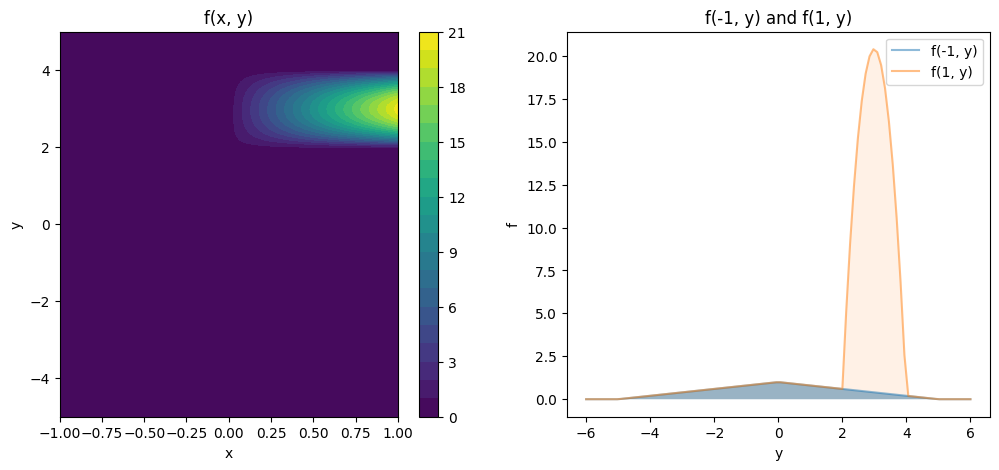

In [3]:
def f(x, y):
    return np.maximum(0, 5 - np.abs(y))/5 + (x > 0) * 20 * x * np.maximum(0, 1 - (y-3)**2)

N = 100
x = np.linspace(-1, 1, N)
y = np.linspace(-5, 5, N)
x, y = np.meshgrid(x, y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.colorbar(ax1.contourf(x, y, f(x, y), 20))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('f(x, y)')

y = np.linspace(-6, 6, N)
ax2.plot(y, f(-1, y), label='f(-1, y)', alpha=0.5)
ax2.fill_between(y, 0, f(-1, y), alpha=0.5)
ax2.plot(y, f(1, y), label='f(1, y)', alpha=0.5)
ax2.fill_between(y, 0, f(1, y), alpha=0.1)
ax2.set_xlabel('y')
ax2.set_ylabel('f')
ax2.set_title('f(-1, y) and f(1, y)')
ax2.legend()
plt.show()

Let's compute the analytic solution for $I(x)$ and $I$.

In [4]:
def I(x):
    return 5 + (x > 0) * 80/3 * x

Ixy = 10 + 40/3

def p(x, y):
    return f(x, y)/Ixy

def px(x):  # marginalized on y
    return I(x)/Ixy

def py_x(y, x):  # conditional distribution
    return f(x, y)/I(x)

def py(y):  # marginalized on x
    return (0.4 * np.maximum(0, 5 - np.abs(y)) + 10 * np.maximum(0, 1 - (y-3)**2)) / Ixy

# Validate the integrals
print(I(1), quad(lambda y: f(1, y), -5, 5))
print(Ixy, quad(I, -1, 1), quad(lambda x: quad(lambda y: f(x, y), -5, 5)[0], -1, 1))
print(1, quad(px, -1, 1))
print(1, quad(py, -5, 5))
print(1, quad(lambda x: quad(lambda y: p(x, y), -5, 5)[0], -1, 1))

31.666666666666668 (31.666666666666668, 3.515706244646329e-14)
23.333333333333336 (23.333333333333332, 2.5934809855243657e-13) (23.333333333529183, 1.326938559031987e-12)
1 (1.0, 1.1102230246251565e-14)
1 (0.9999999999999996, 1.1102230246251561e-15)
1 (1.0000000000046532, 1.1102230246251565e-14)


In [5]:
# %matplotlib ipympl
# N = 100
# y = np.linspace(-6, 6, N)
# fig, ax = plt.subplots()
# iplt.plot(y, lambda y, x_cond: py_x(y, x_cond), x_cond=(-1, 1, N))
# plt.xlabel('y')
# plt.ylabel('p(y|x)')
# plt.show()

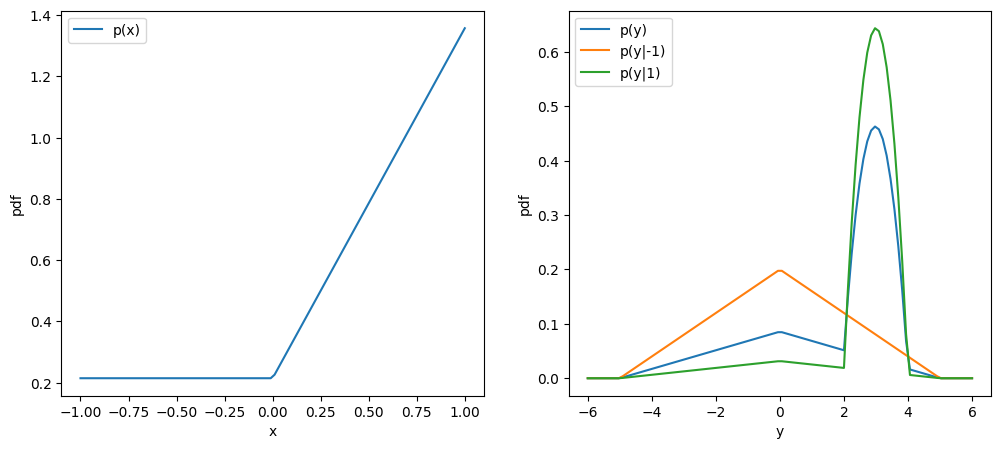

In [6]:
plt.close()
%matplotlib inline
x = np.linspace(-1, 1, N)
y = np.linspace(-6, 6, N)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(x, px(x), label='p(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('pdf')
ax1.legend()

ax2.plot(y, py(y), label='p(y)')
ax2.plot(y, py_x(y, -1), label='p(y|-1)')
ax2.plot(y, py_x(y, 1), label='p(y|1)')
ax2.set_xlabel('y')
ax2.set_ylabel('pdf')
ax2.legend()
plt.show()

## Train Models

Now, let's train the parent and child models using Gaussian Mixtures.

In [7]:
# Generate training data for learning the models
training_samples = 1000
noise_level = 1e-2

def hat_px(x):  # sampling distribution of x
    return np.full_like(x, 0.5)

@np.vectorize
def hat_py_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), -1, 1)[0]

hat_py_normalizer = quad(hat_py_unnorm, -5, 5)[0]

def hat_py(y):  # propto \int p(y|x) \hat{p}_X(x) dx
    return hat_py_unnorm(y) / hat_py_normalizer

@np.vectorize
def hat_ply_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), -1, 0)[0]

hat_ply_normalizer = quad(hat_ply_unnorm, -5, 5)[0]

def hat_ply(y):
    return hat_ply_unnorm(y) / hat_ply_normalizer

@np.vectorize
def hat_pry_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), 0, 1)[0]

hat_pry_normalizer = quad(hat_pry_unnorm, -5, 5)[0]

def hat_pry(y):
    return hat_pry_unnorm(y) / hat_pry_normalizer

X_train = np.random.uniform(-1, 1, training_samples)
Y_train = np.random.uniform(-5, 5, training_samples)
Psy_train = np.full_like(Y_train, fill_value=1/10)  # sampling pdf of y
Z_train = f(X_train, Y_train)
Z_train[Z_train > 0] = np.random.gamma(Z_train[Z_train > 0]**2 / noise_level, noise_level / Z_train[Z_train > 0])  # add noise

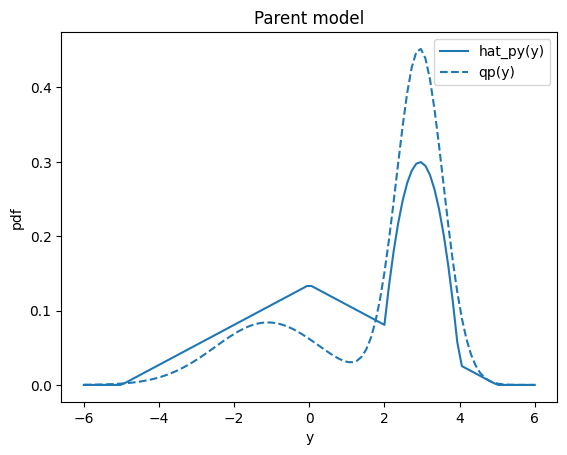

In [8]:
# Train the parent model
gmm_p = GeneralMixtureModel([Normal(), Normal()])
samples = Y_train[:, None].astype(np.float32)
weights = (Z_train / Psy_train)[:, None].astype(np.float32)
gmm_p.fit(samples, weights)

def qp(y):
    return gmm_p.probability(y[:, None]).numpy()

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
plt.plot(y, hat_py(y), label='hat_py(y)', linestyle='-', color='tab:blue')
plt.plot(y, qp(y), label='qp(y)', linestyle='--', color='tab:blue')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.title('Parent model')
plt.show()

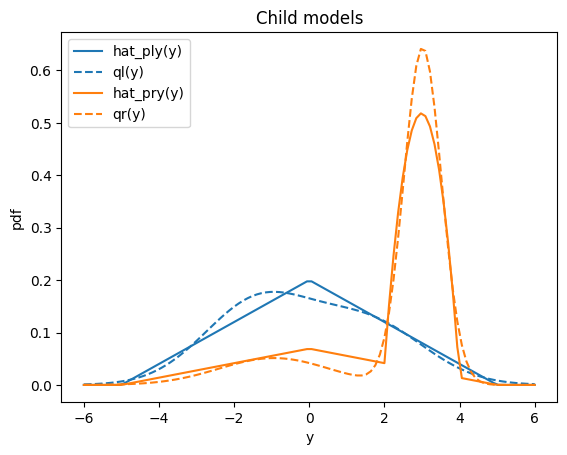

In [9]:
# Train the child model
gmm_l = GeneralMixtureModel([Normal(), Normal()])
gmm_r = GeneralMixtureModel([Normal(), Normal()])
samples_l = samples[X_train <= 0]
weights_l = weights[X_train <= 0]
gmm_l.fit(samples_l, weights_l)
samples_r = samples[X_train > 0]
weights_r = weights[X_train > 0]
gmm_r.fit(samples_r, weights_r)

def ql(y):
    return gmm_l.probability(y[:, None]).numpy()

def qr(y):
    return gmm_r.probability(y[:, None]).numpy()

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
# plt.plot(y, py_x(y, -1), label='p(y|-1)')
# plt.plot(y, py_x(y, 1), label='p(y|1)')
plt.plot(y, hat_ply(y), label='hat_ply(y)', linestyle='-', color='tab:blue')
plt.plot(y, ql(y), label='ql(y)', linestyle='--', color='tab:blue')
plt.plot(y, hat_pry(y), label='hat_pry(y)', linestyle='-', color='tab:orange')
plt.plot(y, qr(y), label='qr(y)', linestyle='--', color='tab:orange')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.title('Child models')
plt.show()

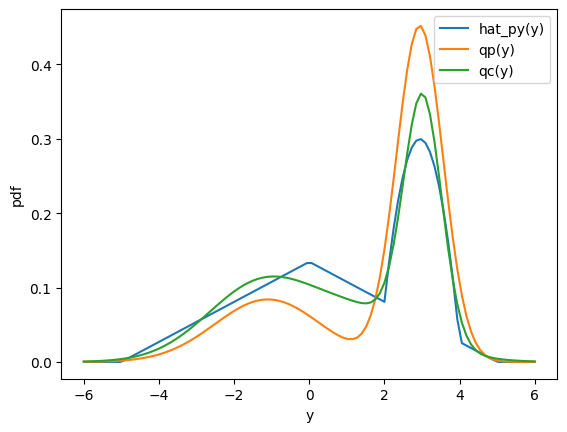

In [10]:
# Show the ensemble model of children

def qc_y_x(y, x):  # conditioned on x
    return np.where(x <= 0, ql(y), qr(y))

@np.vectorize
def qc_y_unnorm(y):  # marginalized
    return quad(lambda x: ql(np.array([y])) * hat_px(x), -1, 0)[0] + quad(lambda x: qr(np.array([y])) * hat_px(x), 0, 1)[0]

qc_y_normalizer = quad(qc_y_unnorm, -5, 5)[0]

def qc_y(y):
    return qc_y_unnorm(y) / qc_y_normalizer

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
plt.plot(y, hat_py(y), label='hat_py(y)')
plt.plot(y, qp(y), label='qp(y)')
plt.plot(y, qc_y(y), label='qc(y)')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.show()

## Evaluation

Now we compute the MC integration MSE for the two models.

In [11]:
# Generate validating data for MC integration
validating_samples = 1000000

X_val = np.random.uniform(-1, 1, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= 0, Y_val_l, Y_val_r)

ests_p = f(X_val, Y_val_p) / qp(Y_val_p)
ests_l = f(X_val, Y_val_l) / ql(Y_val_l)
ests_r = f(X_val, Y_val_r) / qr(Y_val_r)
ests_c = f(X_val, Y_val_c) / qc_y_x(Y_val_c, X_val)
truths = I(X_val)

def MSE(estimates, truths):
    return np.mean((estimates - truths)**2)

def relMSE(estimates, truths):
    return np.mean((estimates - truths)**2 / (truths**2 + 0.01))

print('MSE:')
print('parent,   whole space, left, right:', MSE(ests_p, truths), MSE(ests_p[X_val <= 0], truths[X_val <= 0]), MSE(ests_p[X_val > 0], truths[X_val > 0]))
print('children, whole space, left, right:', MSE(ests_c, truths), MSE(ests_l[X_val <= 0], truths[X_val <= 0]), MSE(ests_r[X_val > 0], truths[X_val > 0]))
print()

print('relMSE:')
print('parent,   whole space, left, right:', relMSE(ests_p, truths), relMSE(ests_p[X_val <= 0], truths[X_val <= 0]), relMSE(ests_p[X_val > 0], truths[X_val > 0]))
print('children, whole space, left, right:', relMSE(ests_c, truths), relMSE(ests_l[X_val <= 0], truths[X_val <= 0]), relMSE(ests_r[X_val > 0], truths[X_val > 0]))

MSE:
parent,   whole space, left, right: 60.3134 35.0683 85.5329
children, whole space, left, right: 20.3578 0.7028 39.9929

relMSE:
parent,   whole space, left, right: 0.8176 1.4022 0.2336
children, whole space, left, right: 0.1670 0.0281 0.3058


So this concludes that the child model approximates the true signals more accurately than the parent one thanks to the fact that it splits the space into two, and has higher representational power.

The downside is that child model has access to fewer samples than the parent, incurring higher variance in the learning. This can be manifested when the noise level is high, samples are not enough, or when the modality of the distribution does not change on $X$.

## End-to-end Tests

In [12]:
def uniform_stratified(low, high, num_samples, num_stratas):
    assert num_samples >= num_stratas and num_samples % num_stratas == 0
    samples = np.random.uniform(0, 1, num_samples)
    strata_width = (high - low) / num_stratas
    samples_per_strata = num_samples // num_stratas
    strata_indices = (np.arange(num_samples) / samples_per_strata).astype(int)
    return (strata_indices + samples) * strata_width + low

def normal(x, mu, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-((x-mu)**2)/(2*std**2))

# plt.figure()
# plt.hist(uniform_stratified(-1, 1, 1000, 100), bins=100, alpha=0.5, label='stratified')
# plt.hist(np.random.uniform(-1, 1, 1000), bins=100, alpha=0.5, label='uniform')
# plt.legend()
# plt.show()

In [1159]:
# Problem definition
plot_learned = False
###### Case 1 ###### whether to split depends on k
# xmin, xmid, xmax = -1, 0, 1
# ymin, ymax = -np.pi, np.pi
# k = 0.0

# def f(x, y):
#     return 1-np.cos(2*y + k*x)

# def I(x):
#     return 1*(ymax - ymin) - 0.5*(np.sin(2*ymax + k*x) - np.sin(2*ymin + k*x))

###### Case 2 ###### should split
# xmin, xmid, xmax = -1, 0, 1
# ymin, ymax = -3, 3

# def f(x, y):
#     return np.where(x <= 0, normal(y, -1, 0.1), normal(y, -1, 0.1) + 2 * normal(y, 1, 0.5))

# def I(x):
#     return np.where(x <= 0, 1, 3)

###### Case 3 ######  left: sun + environ, right: environ, whether to split is sensitive to xmid
xmin, xmid, xmax = -1, +0.1, 1
ymin, ymax = -5, 5

def gate(x):
    return np.clip(1-10*x, 0, 1)

def f(x, y):
    return 10 * gate(x) * normal(y, 0, 0.05) + 1/(ymax - ymin)

def I(x):
    return 10 * gate(x) + 1

##### Uncomment this for arbitarily defined f #####
# @np.vectorize
# def I(x):
#     return quad(lambda y: f(x, y), ymin, ymax)[0]

Ixy = quad(lambda x: I(x), xmin, xmax)[0]

def p(x, y):
    return f(x, y) / Ixy

def py_x(y, x):
    return f(x, y) / I(x)

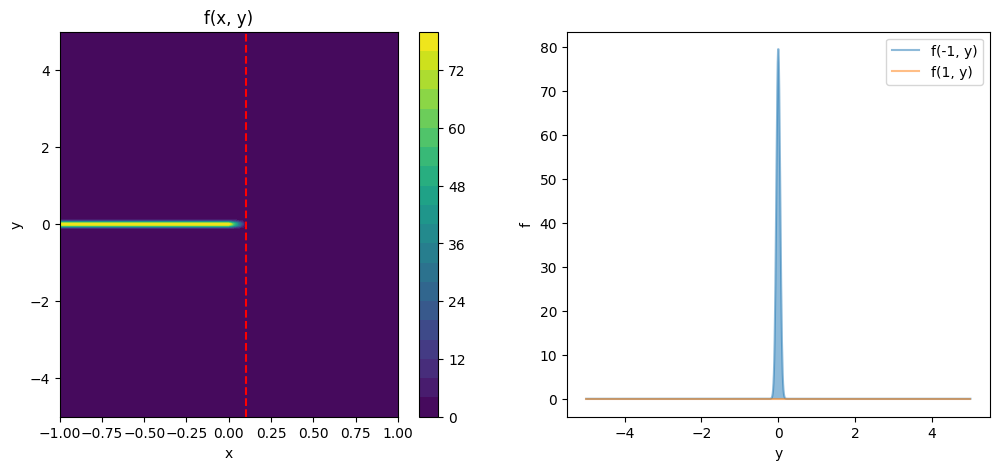

In [1160]:
N = 1000
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
x, y = np.meshgrid(x, y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.colorbar(ax1.contourf(x, y, f(x, y), 20))
ax1.axvline(x=xmid, color='red', linestyle='--')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('f(x, y)')

y = np.linspace(ymin, ymax, N)
ax2.plot(y, f(xmin, y), label=f'f({xmin}, y)', alpha=0.5)
ax2.fill_between(y, 0, f(xmin, y), alpha=0.5)
ax2.plot(y, f(xmax, y), label=f'f({xmax}, y)', alpha=0.5)
ax2.fill_between(y, 0, f(xmax, y), alpha=0.5)
ax2.set_xlabel('y')
ax2.set_ylabel('f')
ax2.legend()
plt.show()

In [1161]:
# Generate training data for learning the models
training_samples = 10000
noise_level = 1e-2
n_components = 4

def f_noisy(x, y):  # noisy observation
    z = f(x, y)
    if noise_level > 0:
        z[z > 1e-3] = np.random.gamma(z[z > 1e-3]**2 / noise_level, noise_level / z[z > 1e-3]) # add noise
    return z

X_train = uniform_stratified(xmin, xmax, training_samples, training_samples)
Y_train = uniform_stratified(ymin, ymax, training_samples, training_samples)
np.random.shuffle(Y_train)
Psy_train = np.full_like(Y_train, fill_value=1/(ymax - ymin))  # sampling pdf of y
Z_train = f_noisy(X_train, Y_train)

# Train the parent model
gmm_p = GeneralMixtureModel([Normal() for _ in range(n_components)])
samples = Y_train[:, None].astype(np.float32)
weights = (Z_train / Psy_train)[:, None].astype(np.float32)
gmm_p.fit(samples[weights[:, 0] > 0], weights[weights[:, 0] > 0])

def qp(y):
    return gmm_p.probability(y[:, None]).numpy()

# Train the child model
gmm_l = GeneralMixtureModel([Normal() for _ in range(n_components)])
gmm_r = GeneralMixtureModel([Normal() for _ in range(n_components)])
samples_l = samples[X_train <= xmid]
weights_l = weights[X_train <= xmid]
gmm_l.fit(samples_l[weights_l[:, 0] > 0], weights_l[weights_l[:, 0] > 0])
samples_r = samples[X_train > xmid]
weights_r = weights[X_train > xmid]
gmm_r.fit(samples_r[weights_r[:, 0] > 0], weights_r[weights_r[:, 0] > 0])

def ql(y):
    return gmm_l.probability(y[:, None]).numpy()

def qr(y):
    return gmm_r.probability(y[:, None]).numpy()

def qc_y_x(y, x):  # conditioned on x
    return np.where(x <= xmid, ql(y), qr(y))


# Plot the learned distribution
if plot_learned:
    # Define some marginalized distributions
    def hat_px(x):  # sampling distribution of x
        return np.full_like(x, 1/(xmax - xmin))

    @np.vectorize
    def hat_py_unnorm(y):
        return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmin, xmax)[0]

    hat_py_normalizer = quad(hat_py_unnorm, ymin, ymax)[0]

    def hat_py(y):  # propto \int p(y|x) \hat{p}_X(x) dx
        return hat_py_unnorm(y) / hat_py_normalizer

    @np.vectorize
    def hat_ply_unnorm(y):
        return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmin, xmid)[0]

    hat_ply_normalizer = quad(hat_ply_unnorm, ymin, ymax)[0]

    def hat_ply(y):
        return hat_ply_unnorm(y) / hat_ply_normalizer

    @np.vectorize
    def hat_pry_unnorm(y):
        return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmid, xmax)[0]

    hat_pry_normalizer = quad(hat_pry_unnorm, ymin, ymax)[0]

    def hat_pry(y):
        return hat_pry_unnorm(y) / hat_pry_normalizer
    
    N = 1000
    y = np.linspace(ymin, ymax, N)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(y, hat_py(y), label='hat_py(y)', linestyle='-', color='tab:blue')
    ax1.plot(y, qp(y), label='qp(y)', linestyle='--', color='tab:blue')
    ax1.set_xlabel('y')
    ax1.set_ylabel('pdf')
    ax1.legend()
    ax1.set_title('Parent model')

    ax2.plot(y, hat_ply(y), label='hat_ply(y)', linestyle='-', color='tab:blue')
    ax2.plot(y, ql(y), label='ql(y)', linestyle='--', color='tab:blue')
    ax2.plot(y, hat_pry(y), label='hat_pry(y)', linestyle='-', color='tab:orange')
    ax2.plot(y, qr(y), label='qr(y)', linestyle='--', color='tab:orange')
    ax2.set_xlabel('y')
    ax2.set_ylabel('pdf')
    ax2.legend()
    ax2.set_title('Child models')

    plt.show()

##### Evaluation #####
# Generate validating data for MC integration
validating_samples = 1000000

# X_val = uniform_stratified(xmin, xmax, validating_samples, validating_samples)
X_val = np.random.uniform(xmin, xmax, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= xmid, Y_val_l, Y_val_r)

ests_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), f(X_val, Y_val_p), 0) / qp(Y_val_p)
ests_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), f(X_val, Y_val_l), 0) / ql(Y_val_l)
ests_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), f(X_val, Y_val_r), 0) / qr(Y_val_r)
ests_c = np.where((ymin <= Y_val_c) & (Y_val_c < ymax), f(X_val, Y_val_c), 0) / qc_y_x(Y_val_c, X_val)
truths = I(X_val)

def ME(estimates, truths):
    return np.mean(estimates - truths)

def MSE(estimates, truths):
    return np.mean((estimates - truths)**2)

def relMSE(estimates, truths):
    return np.mean((estimates - truths)**2 / (truths**2 + 0.01))

print('ME:')
print('parent,   whole space, left, right:', ME(ests_p, truths), ME(ests_p[X_val <= xmid], truths[X_val <= xmid]), ME(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', ME(ests_c, truths), ME(ests_l[X_val <= xmid], truths[X_val <= xmid]), ME(ests_r[X_val > xmid], truths[X_val > xmid]))
print()

print('MSE:')
print('parent,   whole space, left, right:', MSE(ests_p, truths), MSE(ests_p[X_val <= xmid], truths[X_val <= xmid]), MSE(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', MSE(ests_c, truths), MSE(ests_l[X_val <= xmid], truths[X_val <= xmid]), MSE(ests_r[X_val > xmid], truths[X_val > xmid]))
print()

print('relMSE:')
print('parent,   whole space, left, right:', relMSE(ests_p, truths), relMSE(ests_p[X_val <= xmid], truths[X_val <= xmid]), relMSE(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', relMSE(ests_c, truths), relMSE(ests_l[X_val <= xmid], truths[X_val <= xmid]), relMSE(ests_r[X_val > xmid], truths[X_val > xmid]))

ME:
parent,   whole space, left, right: 0.0000 0.0005 -0.0005
children, whole space, left, right: -0.0001 -0.0003 0.0001

MSE:
parent,   whole space, left, right: 21.7765 32.3478 8.8705
children, whole space, left, right: 1.8537 3.3130 0.0722

relMSE:
parent,   whole space, left, right: 4.1336 0.3255 8.7827
children, whole space, left, right: 0.0864 0.0986 0.0714


## Our Divergence Metric

In the rendering application, we have no access to the true integral $I(x)$.  Instead, all observations we have are *noisy* estimates of the integrand $f(x, y)$.

Hence, we propose an empirical KL divergence metric that can be used to determine the quality of the model. The metric is defined as follows:

$$

D^{\hat{p}_X}_{KL} (p || q) := \mathbb{E}_{x \sim \hat{p_X}} \left[ D_{KL}(p_{Y|X} || q_{Y|X}) \right]

$$

Where the $D^{\hat{p}_X}$ denotes that the divergence is averaged over the empirical distribution $\hat{p}_X$. $D_{KL}(p_{Y|X} || q_{Y|X})$ computes the divergence between two conditional distributions - the true $p_{Y|X}$ and the learned model $q_{Y|X}$.

Note that KL divergence boils down to the subtraction of two entropies:

$$

D_{KL}(p || q) = H(p, q) - H(p) 

$$

Where $H(p, q) = - \mathbb{E}_p \log q$ is the cross entropy between the two distributions, $H(p) = - \mathbb{E}_p \log p$ is the entropy of the true distribution.

Pluging this into the definition of the divergence metric, we get:

$$

D^{\hat{p}_X}_{KL} (p || q) = \mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] - \mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}) \right]

$$

The second term on the right hand side is a constant for parent and child models. Hence, we only care about the cross entropy, which we compute using the following MC estimator:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   -\int p(y | x) \log q(y | x) dy   \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \mathbb{E}_{y \sim q_s} \left[ -\frac{p(y | x)}{q_s(y | x)} \log q(y|x) \right]   \right]
 \approx \frac{1}{N} \sum_{i=1}^N \left[ -\frac{p(y_i | x_i)}{q_s(y_i | x_i)} \log q(y_i|x_i) \right]

$$

Where $q_s$ is the pdf of the MC samples $y_i$ at $x_i$, and $x_i$ follows the distribution $\hat{p}_X$.

Note that we have no access to the true probability $p(y|x)$, but only the noisy estimate $\langle f(x, y) \rangle$. Using the relation $p(y|x) = f(x, y) / I(x) = \frac{f(x, y)}{\int f(x, y) dy}$, and $\langle I(x) \rangle = \langle f(x, y) \rangle / q_s(y | x)$, we can rewrite the above estimator as:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ -\frac{ f(x, y) }{I(x) q_s(y | x)} \log q(y|x) \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ -\frac{ \mathbb E \left[ \langle f(x, y) \rangle \right] }{I(x) q_s(y | x)} \log q(y|x) \right] 
 \approx \textcolor{green}{\frac{1}{N} \sum_{i=1}^N -\frac{ \langle I(x_i) \rangle }{I(x_i)} \log q(y_i|x_i)} \\
 \doteq \frac{\frac{1}{N}\sum_{i=1}^N -\langle I(x_i) \rangle \log q(y_i|x_i) } { \frac{1}{N}\sum_{i=1}^N \langle I(x_i) \rangle }
 = \textcolor{orange}{\frac{\sum_{i=1}^N -\langle I(x_i) \rangle \log q(y_i|x_i) } { \sum_{i=1}^N \langle I(x_i) \rangle }}
$$

Notice the $\doteq$ means *biased* estimation due to the split sum.

In our experiments below, we use the green expression to compute the unbiased cross entropy, and the orange one to compute the more empirical biased one.

Similarly, we can derive the $\chi^2$ divergence estimators as follows:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ D_{\chi^2}(p_{Y|X} || q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \int \frac{(p(y | x) - q(y | x))^2}{q(y | x)} dy   \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \int \frac{p(y | x)^2}{q(y | x)} dy -1   \right]
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[   \frac{f(x, y)^2}{I(x)^2 q_s(y | x)q(y | x)} \right] - 1\\
 \doteq \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ \frac{ \langle f(x,y) \rangle ^2 }{ I(x)^2 q_s(y | x)q(y | x) } \right] - 1 
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ \frac{ \langle I(x) \rangle ^2 q_s(y|x) }{ I(x)^2 q(y | x) } \right] - 1  \\
 \doteq \textcolor{orange}{\frac{\sum_{i=1}^N \langle I(x_i) \rangle^2 q_s(y_i | x_i) / q(y_i | x_i)}{\left( \sum_{i=1}^N \langle I(x_i) \rangle \right)^2} - 1}

 $$

 Note that this estimator is biased due to two reasons: the split sum in the last step and $f(x,y)^2 = \mathbb{E}^2 \left[ \langle f(x,y) \rangle \right] \neq \mathbb{E} \left[ \langle f(x,y) \rangle^2 \right]$.

In [1167]:
# Generate validating data to estimate the quality of fitting
validating_samples = 10000

X_val = uniform_stratified(xmin, xmax, validating_samples, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= xmid, Y_val_l, Y_val_r)

f_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), f_noisy(X_val, Y_val_p), 0)
f_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), f_noisy(X_val, Y_val_l), 0)
f_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), f_noisy(X_val, Y_val_r), 0)
f_c = np.where(X_val <= xmid, f_l, f_r)

I_p = f_p / qp(Y_val_p)
I_l = f_l / ql(Y_val_l)
I_r = f_r / qr(Y_val_r)
I_c = f_c / qc_y_x(Y_val_c, X_val)
I_truths = I(X_val)

log_qp = gmm_p.log_probability(Y_val_p[:, None]).numpy()
log_ql = gmm_l.log_probability(Y_val_l[:, None]).numpy()
log_qr = gmm_r.log_probability(Y_val_r[:, None]).numpy()
log_qc = np.where(X_val <= xmid, log_ql, log_qr)

#### Cross entropy metric:

# Compute the unbiased cross entropies
print('Cross entropy: (biased vs unbiased)')
# entropy_true_p = quad(lambda x: 1/(xmax-xmin) * quad(lambda y: -f(x, y) * gmm_p.log_probability([[y]]).numpy() / (I(x) + 1e-3), ymin, ymax)[0], xmin, xmax)[0]
# print('Entropy true parent:   ', entropy_true_p)

entropy_unbiased_p = np.mean(-I_p / (I_truths + 1e-3) * log_qp)
entropy_biased_pl = np.mean(-I_p[X_val <= xmid] * log_qp[X_val <= xmid]) / np.mean(I_p[X_val <= xmid])
entropy_biased_pr = np.mean(-I_p[X_val > xmid] * log_qp[X_val > xmid]) / np.mean(I_p[X_val > xmid])
entropy_biased_p_corrected = (entropy_biased_pl * (X_val <= xmid).sum() + entropy_biased_pr * (X_val > xmid).sum()) / validating_samples
# entropy_biased_p = np.mean(-I_p * log_qp) / np.mean(I_p)
entropy_biased_p = entropy_biased_p_corrected
print('Parent:      {0:f}              {1:f}'.format(entropy_biased_p, entropy_unbiased_p))

entropy_unbiased_l = np.mean(-I_l[X_val <= xmid] / (I_truths[X_val <= xmid] + 1e-3) * log_ql[X_val <= xmid])
entropy_biased_l = np.mean(-I_l[X_val <= xmid] * log_ql[X_val <= xmid]) / np.mean(I_l[X_val <= xmid])
entropy_unbiased_r = np.mean(-I_r[X_val > xmid] / (I_truths[X_val > xmid] + 1e-3) * log_qr[X_val > xmid])
entropy_biased_r = np.mean(-I_r[X_val > xmid] * log_qr[X_val > xmid]) / np.mean(I_r[X_val > xmid])
entropy_unbiased_c = np.mean(-I_c / (I_truths + 1e-3) * log_qc)
# entropy_biased_c = np.mean(-I_c * log_qc) / np.mean(I_c)
entropy_biased_c = (np.sum(-I_c[X_val <= xmid] * log_ql[X_val <= xmid]) / np.mean(I_c[X_val <= xmid]) + np.sum(-I_c[X_val > xmid] * log_qr[X_val > xmid]) / np.mean(I_c[X_val > xmid])) / validating_samples
print('Left child:  {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_l, entropy_biased_l - entropy_biased_p, entropy_unbiased_l, entropy_unbiased_l - entropy_unbiased_p))
print('Right child: {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_r, entropy_biased_r - entropy_biased_p, entropy_unbiased_r, entropy_unbiased_r - entropy_unbiased_p))
print('Child:       {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_c, entropy_biased_c - entropy_biased_p, entropy_unbiased_c, entropy_unbiased_c - entropy_unbiased_p))

if entropy_biased_c < entropy_biased_p:
    print('Yes, split!')
else:
    print('No, do not split!')

# entropy_true_c = quad(lambda x: 1/(xmax-xmin) * quad(lambda y: -f(x, y) * (gmm_l.log_probability([[y]]).numpy() if x <= xmid else gmm_r.log_probability([[y]])) / (I(x) + 1e-3), ymin, ymax)[0], xmin, xmax)[0]
# print('Entropy true child:    ', entropy_true_c)
print()

#### Chi2 divergence metric:
# entropy_unbiased_p = np.mean(-I_p / (I_truths + 1e-3) * log_qp)
chi2_biased_pl = np.mean(I_p[X_val <= xmid]**2) / np.mean(I_p[X_val <= xmid])**2 - 1
chi2_biased_pr = np.mean(I_p[X_val > xmid]**2) / np.mean(I_p[X_val > xmid])**2 - 1
chi2_biased_p_corrected = (chi2_biased_pl * (X_val <= xmid).sum() + chi2_biased_pr * (X_val > xmid).sum()) / validating_samples
chi2_biased_p = chi2_biased_p_corrected
# chi2_biased_p = np.mean(I_p**2) / np.mean(I_p)**2 - 1
chi2_biased_l = np.mean(I_l[X_val <= xmid]**2) / np.mean(I_l[X_val <= xmid])**2 - 1
chi2_biased_r = np.mean(I_r[X_val > xmid]**2) / np.mean(I_r[X_val > xmid])**2 - 1
# chi2_biased_c = np.mean(I_c**2) / np.mean(I_c)**2 - 1
chi2_biased_c = (np.sum(I_c[X_val <= xmid]**2) / np.mean(I_c[X_val <= xmid])**2 + np.sum(I_c[X_val > xmid]**2) / np.mean(I_c[X_val > xmid])**2) / validating_samples - 1


print('Chi2 divergence: (biased)')
print('Parent:      {0:f}'.format(chi2_biased_p))
print('Left child:  {0:f} ({1:+.1f}%)'.format(chi2_biased_l, 100*(chi2_biased_l - chi2_biased_p) / (chi2_biased_p)))
print('Right child: {0:f} ({1:+.1f}%)'.format(chi2_biased_r, 100*(chi2_biased_r - chi2_biased_p) / (chi2_biased_p)))
print('Child:       {0:f} ({1:+.1f}%)'.format(chi2_biased_c, 100*(chi2_biased_c - chi2_biased_p) / (chi2_biased_p)))

if chi2_biased_c < chi2_biased_p:
    print('Yes, split!')
else:
    print('No, do not split!')

Cross entropy: (biased vs unbiased)
Parent:      1.524162              1.694646
Left child:  -0.826367 (-2.350528)  -0.726919 (-2.421566)
Right child: 2.336478 (+0.812316)  2.357878 (+0.663232)
Child:       0.596913 (-0.927248)  0.661240 (-1.033407)
Yes, split!

Chi2 divergence: (biased)
Parent:      7.740391
Left child:  0.178885 (-97.7%)
Right child: 1.093997 (-85.9%)
Child:       0.590685 (-92.4%)
Yes, split!


In [1168]:
# Unbiased divergence metrics

def kl_div(p, q):
    d = np.zeros_like(p)
    d[p > 0] = p[p > 0] / q[p > 0] * np.log(p[p > 0] / q[p > 0])
    return np.mean(d)

def cross_entropy(p, q):
    e = np.zeros_like(p)
    e[p > 0] = -p[p > 0] / q[p > 0] * np.log(q[p > 0])
    return np.mean(e)

def chi2_div(p, q):
    return np.mean((p - q)**2 / q**2)

for metric, name in [(kl_div, 'KL divergence'), (chi2_div, 'Chi2 divergence')]:
    py_x_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), py_x(Y_val_p, X_val), 0)
    div_p = metric(py_x_p, qp(Y_val_p))

    py_x_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), py_x(Y_val_l, X_val), 0)
    div_l = metric(py_x_l[X_val <= xmid], ql(Y_val_l[X_val <= xmid]))

    py_x_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), py_x(Y_val_r, X_val), 0)
    div_r = metric(py_x_r[X_val > xmid], qr(Y_val_r[X_val > xmid]))

    py_x_c = np.where((ymin <= Y_val_c) & (Y_val_c < ymax), py_x(Y_val_c, X_val), 0)
    div_c = metric(py_x_c, qc_y_x(Y_val_c, X_val))

    print(f'{name}:')
    print('Parent:     ', div_p)
    print('Left child: ', div_l, f"{100*(div_l - div_p) / div_p:+.1f}%")
    print('Right child:', div_r, f"{100*(div_r - div_p) / div_p:+.1f}%")
    print('Child model:', div_c, f"{100*(div_c - div_p) / div_p:+.1f}%")
    if div_c < div_p:
        print('Should have splitted!')
    else:
        print('No need to split!')
    print()

KL divergence:
Parent:      1.0282
Left child:  0.0510 -95.0%
Right child: 0.0385 -96.3%
Child model: 0.0454 -95.6%
Should have splitted!

Chi2 divergence:
Parent:      4.3951
Left child:  0.1441 -96.7%
Right child: 0.0638 -98.5%
Child model: 0.1080 -97.5%
Should have splitted!



In [1169]:
# cross_entropy(py_x_l[X_val <= xmid], ql(Y_val_l[X_val <= xmid]))
# cross_entropy(py_x_r[X_val > xmid], ql(Y_val_r[X_val > xmid]))
cross_entropy(py_x_p, qp(Y_val_p)), cross_entropy(py_x_c, qc_y_x(Y_val_c, X_val))
# cross_entropy(py_x_p[X_val <= xmid], qp(Y_val_p[X_val <= xmid]))
# cross_entropy(py_x_p[X_val > xmid], qp(Y_val_p[X_val > xmid]))
# quad(lambda y: -hat_ply(y) * gmm_l.log_probability([[y]]).numpy(), ymin, ymax)
# quad(lambda y: -hat_pry(y) * gmm_r.log_probability([[y]]).numpy(), ymin, ymax)

(1.6418147947564445, 0.6418668506551363)

In [1170]:
entropy_biased_pl = np.mean(-I_p[X_val <= xmid] * log_qp[X_val <= xmid]) / np.mean(I_p[X_val <= xmid])
entropy_biased_pr = np.mean(-I_p[X_val > xmid] * log_qp[X_val > xmid]) / np.mean(I_p[X_val > xmid])
(entropy_biased_pl * (X_val <= xmid).sum() + entropy_biased_pr * (X_val > xmid).sum()) / validating_samples

1.5241615166921303

In [1171]:
(entropy_biased_l * (X_val <= xmid).sum() + entropy_biased_r * (X_val > xmid).sum()) / validating_samples, (entropy_unbiased_l * (X_val <= xmid).sum() + entropy_unbiased_r * (X_val > xmid).sum()) / validating_samples

(0.5969134141135384, 0.6612396405643893)